<a href="https://colab.research.google.com/github/SMN-SENAMHI/S2S/blob/main/surface_week.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quickstart: NOAA GEFS forecast, 35 day - dynamical.org zarr
Este recurso ofrece una introducción rápida al conjunto de datos del modelo de pronóstico NOAA GEFS (Global Ensemble Forecast System) con horizonte de 35 días, el cual ha sido transformado por Dynamical.org a un formato listo para análisis y optimizado para la nube utilizando Zarr.

*El conjunto de datos incluye variables meteorológicas y climáticas clave, en una estructura que permite:

*Acceso rápido y eficiente desde plataformas en la nube.

*Procesamiento paralelo y en tiempo real para aplicaciones de ciencia de datos, inteligencia artificial o visualización.

*Exploración del pronóstico extendido (S2S: subseasonal to seasonal) con múltiples miembros del ensamble.

🔗 Documentación completa del conjunto de datos:
https://dynamical.org/catalog/noaa-gefs-forecast-35-day/



In [1]:
%pip install "xarray[complete]>=2025.1.2" "zarr>=3.0.4" requests aiohttp > /dev/null 2>&1
!apt-get install -y libproj-dev proj-data proj-bin libgeos-dev > /dev/null 2>&1
!pip install cython > /dev/null 2>&1
!pip install cartopy > /dev/null 2>&1
!pip install geopy > /dev/null 2>&1


In [2]:
import xarray as xr
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# ============================
# 1. Abrir dataset GEFS (Zarr)
# ============================
url = "https://data.dynamical.org/noaa/gefs/forecast-35-day/latest.zarr?email=optional@email.com"
ds = xr.open_zarr(url, decode_timedelta=True)

# ============================
# 2. Variables disponibles
# ============================
print("\n Variables disponibles en el dataset GEFS:")
for var in ds.data_vars:
    units = ds[var].attrs.get("units", "")
    desc = ds[var].attrs.get("long_name", "")
    print(f" - {var}: {desc} [{units}]")

# ============================
# 3. Fechas de inicio de pronóstico
# ============================
if "init_time" in ds.coords:
    t0 = pd.to_datetime(ds.init_time.values[0])
    tf = pd.to_datetime(ds.init_time.values[-1])
    print("\n Rango temporal de 'init_time':")
    print("Inicio :", t0.strftime("%Y-%m-%d %H:%M:%S"))
    print("Fin    :", tf.strftime("%Y-%m-%d %H:%M:%S"))

# ============================
# 4. Información de ensembles
# ============================
if "ensemble_member" in ds.dims:
    n_ens = ds.dims["ensemble_member"]
    ens_vals = ds["ensemble_member"].values
    print(f"\n Número de miembros en el ensamble: {n_ens}")
    print("Listado de ensemble_member:")
    print(ens_vals)



 Variables disponibles en el dataset GEFS:
 - categorical_freezing_rain_surface: Categorical freezing rain [0=no; 1=yes]
 - categorical_ice_pellets_surface: Categorical ice pellets [0=no; 1=yes]
 - categorical_rain_surface: Categorical rain [0=no; 1=yes]
 - categorical_snow_surface: Categorical snow [0=no; 1=yes]
 - downward_long_wave_radiation_flux_surface: Surface downward long-wave radiation flux [W/(m^2)]
 - downward_short_wave_radiation_flux_surface: Surface downward short-wave radiation flux [W/(m^2)]
 - geopotential_height_cloud_ceiling: Geopotential height [gpm]
 - maximum_temperature_2m: Maximum temperature [C]
 - minimum_temperature_2m: Minimum temperature [C]
 - percent_frozen_precipitation_surface: Percent frozen precipitation [%]
 - precipitable_water_atmosphere: Precipitable water [kg/(m^2)]
 - precipitation_surface: Total Precipitation [mm/s]
 - pressure_reduced_to_mean_sea_level: Pressure reduced to MSL [Pa]
 - pressure_surface: Surface pressure [Pa]
 - relative_humidi

In [3]:
#@title Selección de parámetros

# Dropdown de países
Pais_seleccion = "Colombia" #@param ["Brasil", "Colombia", "Venezuela", "Argentina", "Bolivia", "Chile", "Costa Rica", "Ecuador", "French Guiana", "Guyana", "Océano Pacífico", "Panamá", "Paraguay", "Perú", "Suriname", "Uruguay"]

# Calendario para fecha de inicio
Fecha_inicio = "2025-09-23" #@param {type:"date"}

print(f" País seleccionado: {Pais_seleccion}")
print(f" Fecha seleccionada: {Fecha_inicio}")

 País seleccionado: Colombia
 Fecha seleccionada: 2025-09-23


In [7]:
#@title Configuración inicial
import os, requests, xarray as xr, matplotlib.pyplot as plt, cartopy.crs as ccrs
import numpy as np, pandas as pd, geopandas as gpd
from matplotlib.colors import BoundaryNorm
import dask
from dask.distributed import Client, LocalCluster
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger("distributed").setLevel(logging.CRITICAL)


# Configurar Dask
cluster = LocalCluster(n_workers=2, threads_per_worker=2, memory_limit="2GB")
client = Client(cluster)

# Descargar shapefile
def download_file(url, local_path):
    r = requests.get(url, stream=True)
    if r.status_code == 200:
        with open(local_path, "wb") as f:
            f.write(r.content)

shapefiles = {
    "SUDAMERICA.shp": "https://raw.githubusercontent.com/SMN-SENAMHI/Materiales/main/shape/SUDAMERICA.shp",
    "SUDAMERICA.dbf": "https://raw.githubusercontent.com/SMN-SENAMHI/Materiales/main/shape/SUDAMERICA.dbf",
    "SUDAMERICA.shx": "https://raw.githubusercontent.com/SMN-SENAMHI/Materiales/main/shape/SUDAMERICA.shx",
}
for name, url in shapefiles.items():
    download_file(url, name)

# Leer shapefile y corregir nombres
gdf = gpd.read_file("SUDAMERICA.shp").set_crs("EPSG:32718").to_crs("EPSG:4326")
gdf["NOMBRE"] = gdf["NOMBRE"].replace({"PerÃº": "Perú", "Panama": "Panamá"})

gdf_pais = gdf[gdf["NOMBRE"].str.upper() == Pais_seleccion.upper()]
if gdf_pais.empty:
    raise ValueError(f"No se encontró el país '{Pais_seleccion}' en el shapefile.")
minx, miny, maxx, maxy = gdf_pais.total_bounds
print("Bounds:", gdf_pais.total_bounds)

Bounds: [-81.72248956  -4.21284381 -66.87218649  12.58706355]


In [8]:
#@title Abrir dataset GEFS
url = "https://data.dynamical.org/noaa/gefs/forecast-35-day/latest.zarr?email=correo@ejemplo.com"
ds = xr.open_zarr(url, chunks={"forecast_time": 50, "latitude": 50, "longitude": 50}, decode_timedelta=True)

init_time = ds.init_time.values[-1]
ds = ds.sel(init_time=init_time)
forecast_time = pd.to_datetime(ds.init_time.values) + pd.to_timedelta(ds.lead_time.values)
ds = ds.assign_coords(forecast_time=("lead_time", forecast_time)).swap_dims({"lead_time": "forecast_time"})
print("Usando init_time:", pd.to_datetime(init_time))

Usando init_time: 2025-09-24 00:00:00


In [9]:
#@title Procesar una variable
var = "tmax" #@param ["precip", "tmax", "tmin"]

if var == "tmax":
    data = ds["maximum_temperature_2m"].resample(forecast_time="7D").mean().mean(dim="ensemble_member").compute()
    cmap = "RdYlBu_r"; bounds = np.arange(-5, 38, 3); label = "Tmax semanal (°C)"
elif var == "tmin":
    data = ds["minimum_temperature_2m"].resample(forecast_time="7D").mean().mean(dim="ensemble_member").compute()
    cmap = "RdYlBu_r"; bounds = np.arange(-5, 38, 3); label = "Tmin semanal (°C)"
else:
    data = (ds["precipitation_surface"]*86400).resample(forecast_time="7D").sum().mean(dim="ensemble_member").compute()
    cmap = "Blues"; bounds = [0, 5, 10, 20, 40, 60, 80, 120, 160, 200,260,300,360]; label = "Precipitación semanal (mm)"

print("Variable procesada:", var)

Variable procesada: tmax


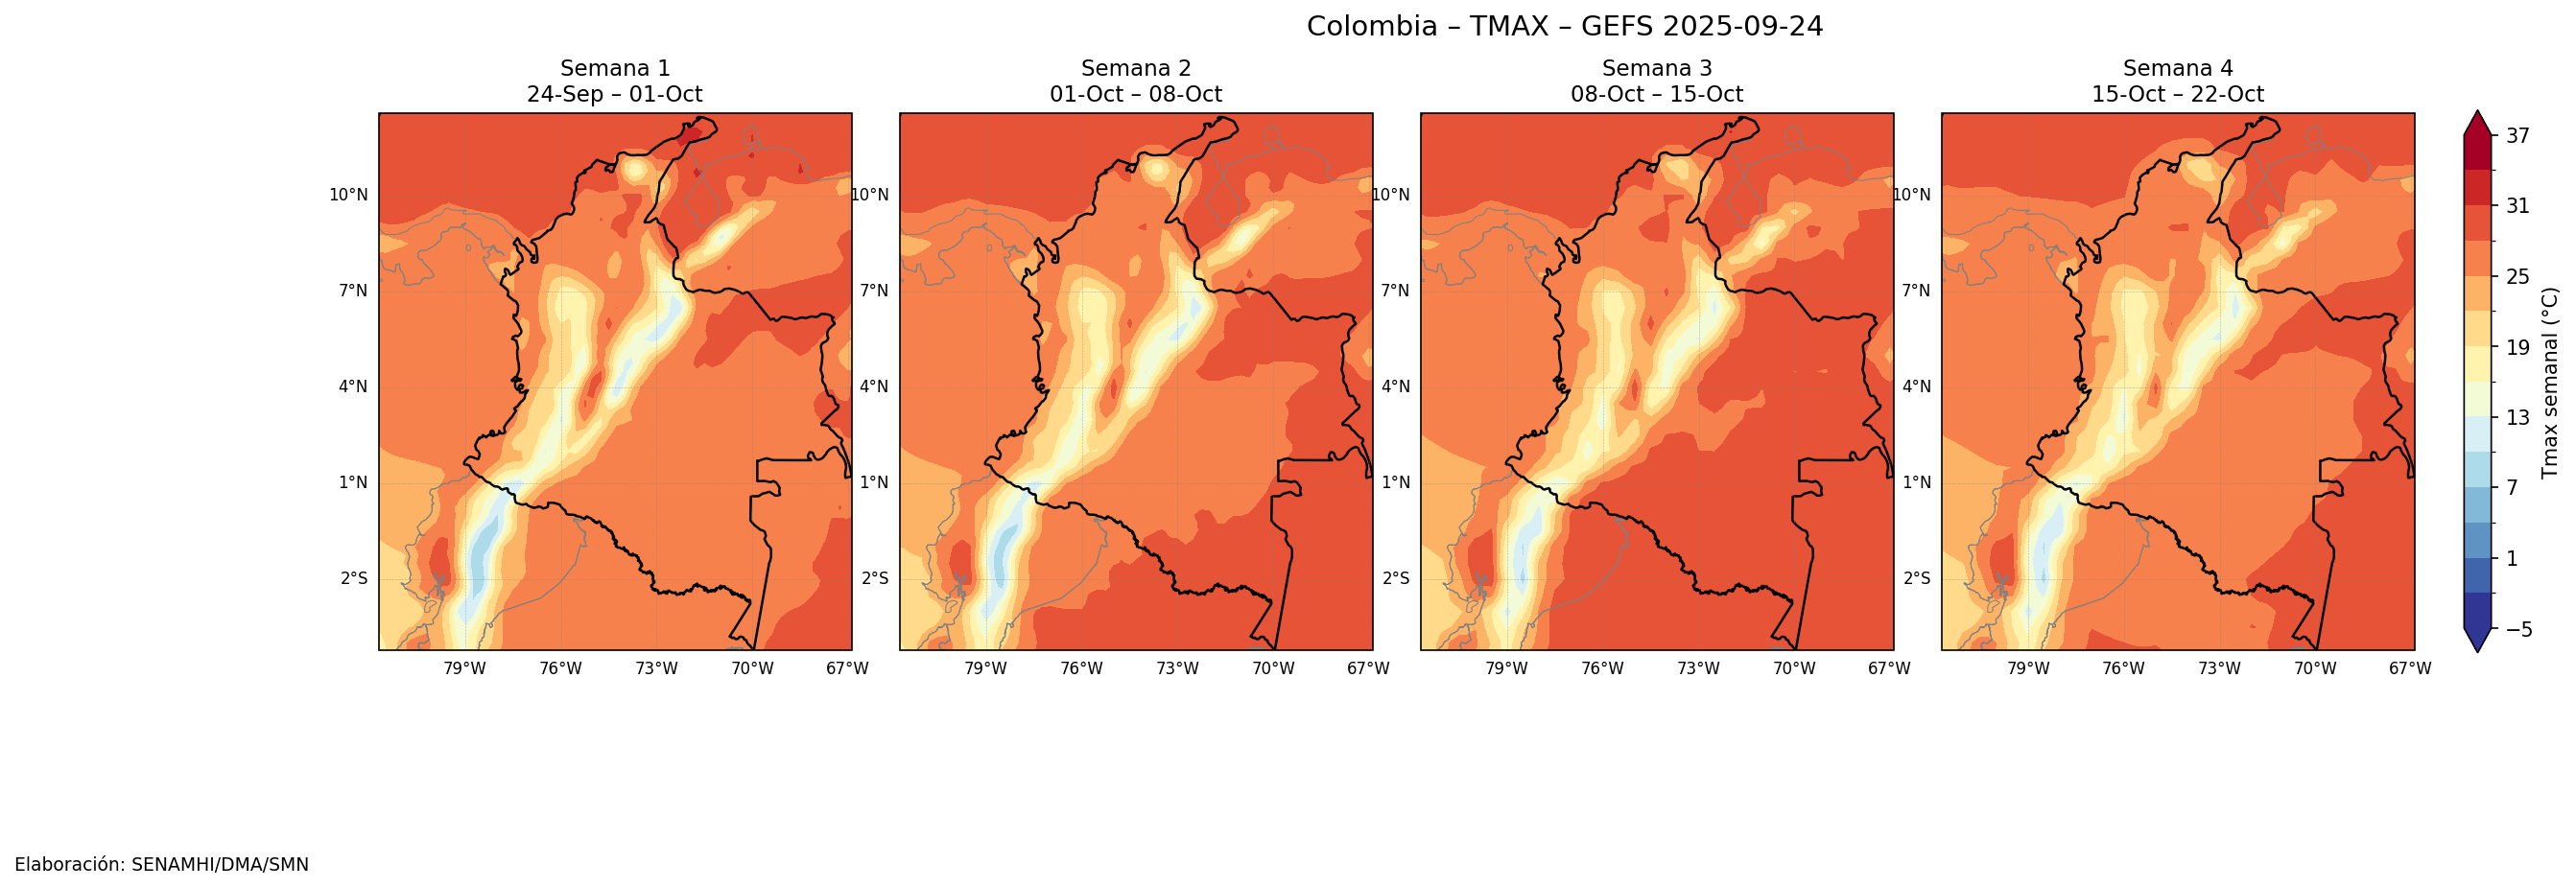

In [11]:
#@title Graficar resultados con lat/lon
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

fig, axes = plt.subplots(1, 4, figsize=(22, 7),
                         subplot_kw={'projection': ccrs.PlateCarree()},
                         dpi=150)
fig.subplots_adjust(wspace=0.1, hspace=0.25)

for i, ax in enumerate(axes):
    field = data.isel(forecast_time=i)
    lon, lat, values = field.longitude.values, field.latitude.values, field.values.squeeze()

    norm = BoundaryNorm(bounds, ncolors=256)
    cs = ax.contourf(lon, lat, values,
                     levels=bounds, cmap=cmap, norm=norm,
                     extend="both", transform=ccrs.PlateCarree())

    gdf.boundary.plot(ax=ax, color="gray", linewidth=0.5)
    gdf_pais.boundary.plot(ax=ax, color="black", linewidth=1.2)
    ax.set_extent([minx, maxx, miny, maxy], crs=ccrs.PlateCarree())

    gl = ax.gridlines(draw_labels=True, linewidth=0.3, color="gray", alpha=0.5, linestyle="--")
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {"size": 8}
    gl.ylabel_style = {"size": 8}

    gl.xlocator = mticker.FixedLocator(np.arange(np.floor(minx/5)*5, np.ceil(maxx/5)*5+1, 3))
    gl.ylocator = mticker.FixedLocator(np.arange(np.floor(miny/5)*5, np.ceil(maxy/5)*5+1, 3))

    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    start_date = pd.to_datetime(str(data.forecast_time[i].values)).strftime("%d-%b")
    if i+1 < len(data.forecast_time):
        end_date = pd.to_datetime(str(data.forecast_time[i+1].values)).strftime("%d-%b")
    else:
        end_date = ""
    ax.set_title(f"Semana {i+1}\n{start_date} – {end_date}", fontsize=11)

cbar = fig.colorbar(cs, ax=axes.ravel().tolist(),
                    orientation="vertical", shrink=0.7, pad=0.02)
cbar.set_label(label)

plt.suptitle(f"{Pais_seleccion} – {var.upper()} – GEFS {pd.to_datetime(init_time).strftime('%Y-%m-%d')}",
             fontsize=14, y=0.86)

plt.figtext(0.01, 0.01, "Elaboración: SENAMHI/DMA/SMN",
            ha="left", fontsize=9, color="black",
            bbox=dict(facecolor="white", alpha=0.6, edgecolor="none"))

plt.show()
